In [1]:
import numpy as np
import torch
import itertools
from torch import nn
import copy
from tqdm import tqdm

In [2]:
import math
import numpy as np

def lz_complexity(s):
    i, k, l = 0, 1, 1
    k_max = 1
    n = len(s) - 1
    c = 1
    while True:
        if s[i + k - 1] == s[l + k - 1]:
            k = k + 1
            if l + k >= n - 1:
                c = c + 1
                break
        else:
            if k > k_max:
                k_max = k
            i = i + 1
            if i == l:
                c = c + 1
                l = l + k_max
                if l + 1 > n:
                    break
                else:
                    i = 0
                    k = 1
                    k_max = 1
            else:
                k = 1
    return c

def decimal(x):
    n = len(x)
    output = 0
    for i in range(len(x)):
        output += x[i]*2**(n-1-i)
    return output

def K_lemp_ziv(sequence):
    if (np.sum(sequence == 0) == len(sequence)) or (np.sum(sequence == 1) == len(sequence)) :

        out = math.log2(len(sequence))
    else:
        forward = sequence
        backward = sequence[::-1]

        out = math.log2(len(sequence))*(lz_complexity(forward) + lz_complexity(backward))/2

    return out

In [72]:
import torch
import torch.nn as nn
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
import itertools
import math


class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, nl=2):
        super(SimpleNN, self).__init__()
        self.nl = nl
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.relu = nn.ReLU()
        self.fcs = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim, bias=False) for _ in range(self.nl-1)])
        self.fc2 = nn.Linear(hidden_dim, 1, bias=False)
        
    def get_features(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        if self.nl > 1:
            for fc in self.fcs:
                x = fc(x)
                x = self.relu(x)
        return x
    
    def forward(self, x):
        features = self.get_features(x)
        output = self.fc2(features)
        return output

def generate_data(dim):
    inputs = [[0, 1] for _ in range(dim)]
    inputs = list(itertools.product(*inputs))
    return torch.Tensor(np.array(inputs))

def analyze_eigenfunctions(model, inputs, num_eigenfunctions=None):
    model.eval()
    
    with torch.no_grad():
        features = model.get_features(inputs)
        features = features.detach().numpy()
    
    # Transpose features to get correct dimensions for SVD
    features = features.T  # Now shape is (hidden_dim, num_samples)
    
    # Perform SVD
    U, s, Vt = svd(features, full_matrices=False)
    
    # Calculate eigenvalues
    eigenvalues = s ** 2
    
    if num_eigenfunctions is None:
        num_eigenfunctions = min(len(s), features.shape[0])
    
    eigenfunctions = []
    with torch.no_grad():
        readout_weights = model.fc2.weight.detach().numpy().flatten()
    
    for k in range(num_eigenfunctions):
        # Compute k-th eigenfunction: e_k(x) = u_k^T Φ(x) / s_k
        uk = U[:, k]
        eigenfunction_values = np.dot(features.T, uk) / s[k]
        
        # Apply readout map
        mapped_values = eigenfunction_values * readout_weights.sum()
        
        # Binarize the output
        binarized_values = (mapped_values > 0).astype(int)
        eigenfunctions.append(binarized_values)
    
    # Calculate complexity for each eigenfunction
    complexities = np.array([K_lemp_ziv(ef) for ef in eigenfunctions])
    
    return eigenvalues[:num_eigenfunctions], eigenfunctions, complexities

def plot_complexity_vs_rank(complexities, eigenvalues, dim, hidden_dim, title="Complexity vs. Eigenfunction Rank"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(complexities) + 1), complexities,'o-', color='#6366F1', 
                    linewidth=1, markersize=2, label='Complexity')
    plt.xlabel('Eigenfunction Rank')
    plt.ylabel('Lempel-Ziv Complexity')
    
    ax2 = plt.twinx()
    ax2.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'r--', alpha=0.5, label='Eigenvalue')
    ax2.set_ylabel('Eigenvalue', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_xlim(0,2000)
    ax2.set_yscale('log')
    
    plt.title(f"{title}\nDim: {dim}, Hidden Dim: {hidden_dim}")
    plt.grid(True, alpha=0.3)
    plt.show()

def run_analysis(dim, hidden_dim, nl=2):
    # Generate data
    data = generate_data(dim)
    
    # Initialize model
    model = SimpleNN(input_dim=dim, hidden_dim=hidden_dim, nl=nl)
    
    # Run analysis
    eigenvalues, eigenfunctions, complexities = analyze_eigenfunctions(model, data)
    
    
    return eigenvalues, eigenfunctions, complexities


# Hyperparameters
dim = 10  # Input dimension
hidden_dim = 2000  # Hidden layer dimension
nl = 4  # Number of layers

# Run analysis
eigenvalues, eigenfunctions, complexities = run_analysis(dim, hidden_dim, nl)

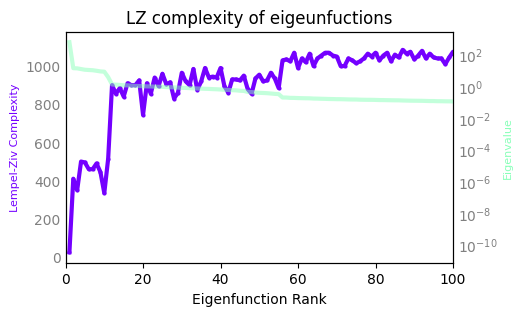

In [73]:
def plot_complexity_vs_rank(complexities, eigenvalues, dim, hidden_dim):
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, len(complexities) + 1), complexities,'o-', color='#7400FF', 
                    linewidth=3, markersize=2, label='Complexity')
    plt.xlabel('Eigenfunction Rank')
    plt.tick_params(axis='y', labelcolor='grey',size=0)
    
    plt.ylabel('Lempel-Ziv Complexity',color="#7400FF",fontsize=8)
    
    ax2 = plt.twinx()
    ax2.plot(range(1, len(eigenvalues) + 1), eigenvalues,color="#89FFB9",linewidth=3, alpha=0.5, label='Eigenvalue')
    ax2.set_ylabel('Eigenvalue', color='#89FFB9',fontsize=8)
    ax2.tick_params(axis='y', labelcolor='grey',size=0)
    ax2.set_xlim(0,100)
    ax2.set_yscale('log')
    ax2.grid(False)


    
        
    plt.title("LZ complexity of eigeunfuctions")
    plt.grid(False)
    plt.show()

plot_complexity_vs_rank(complexities, eigenvalues, dim, hidden_dim)

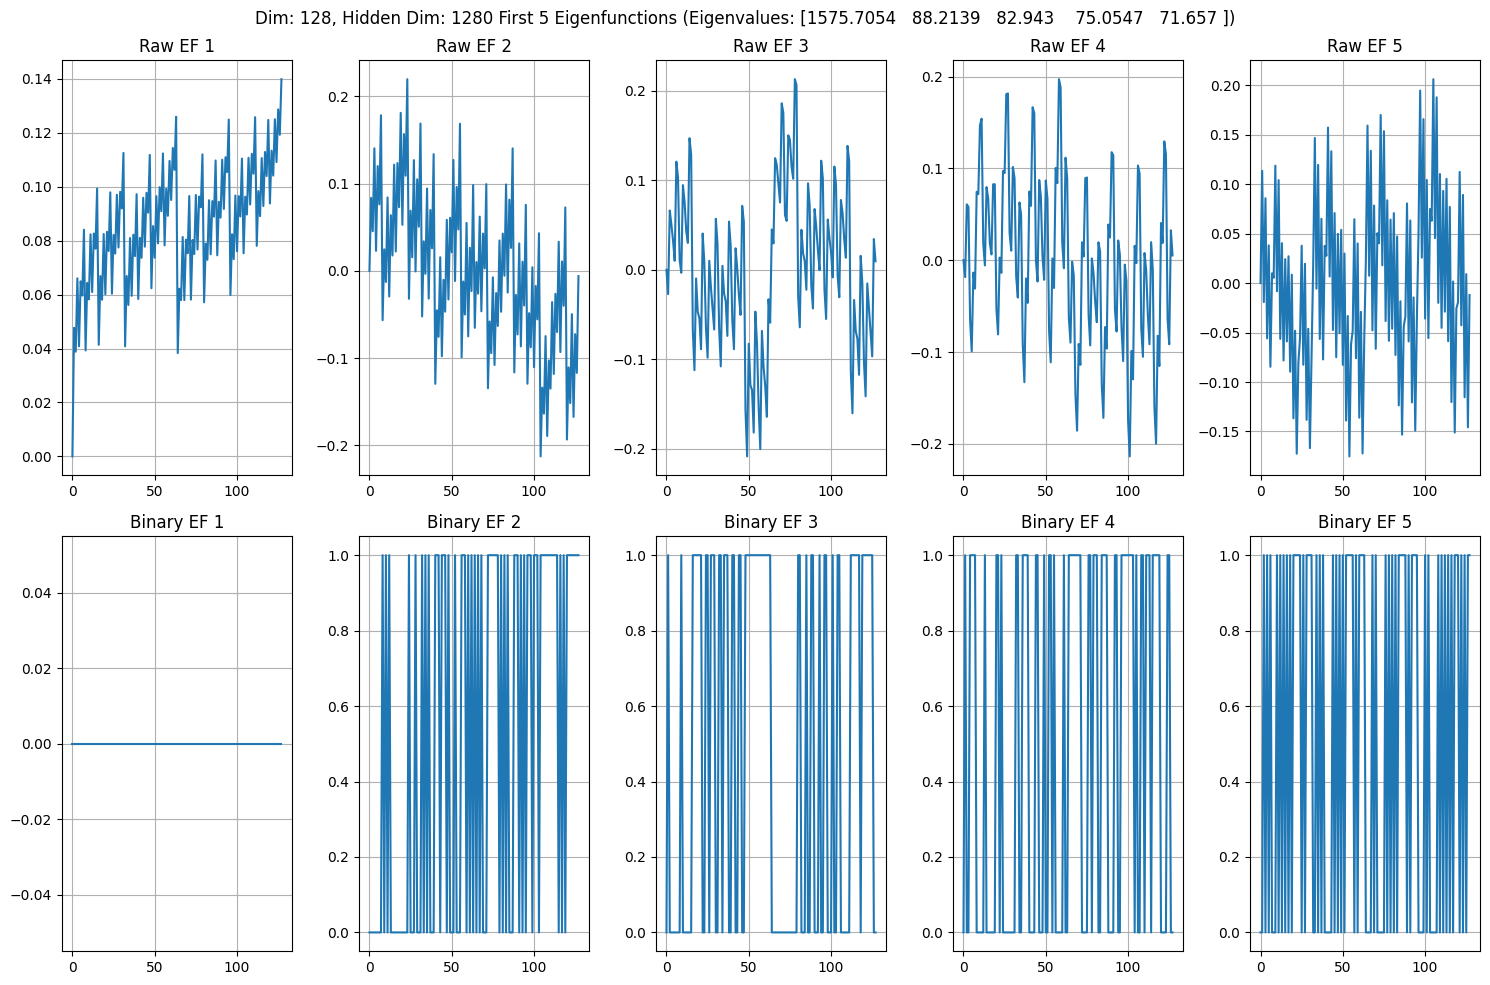

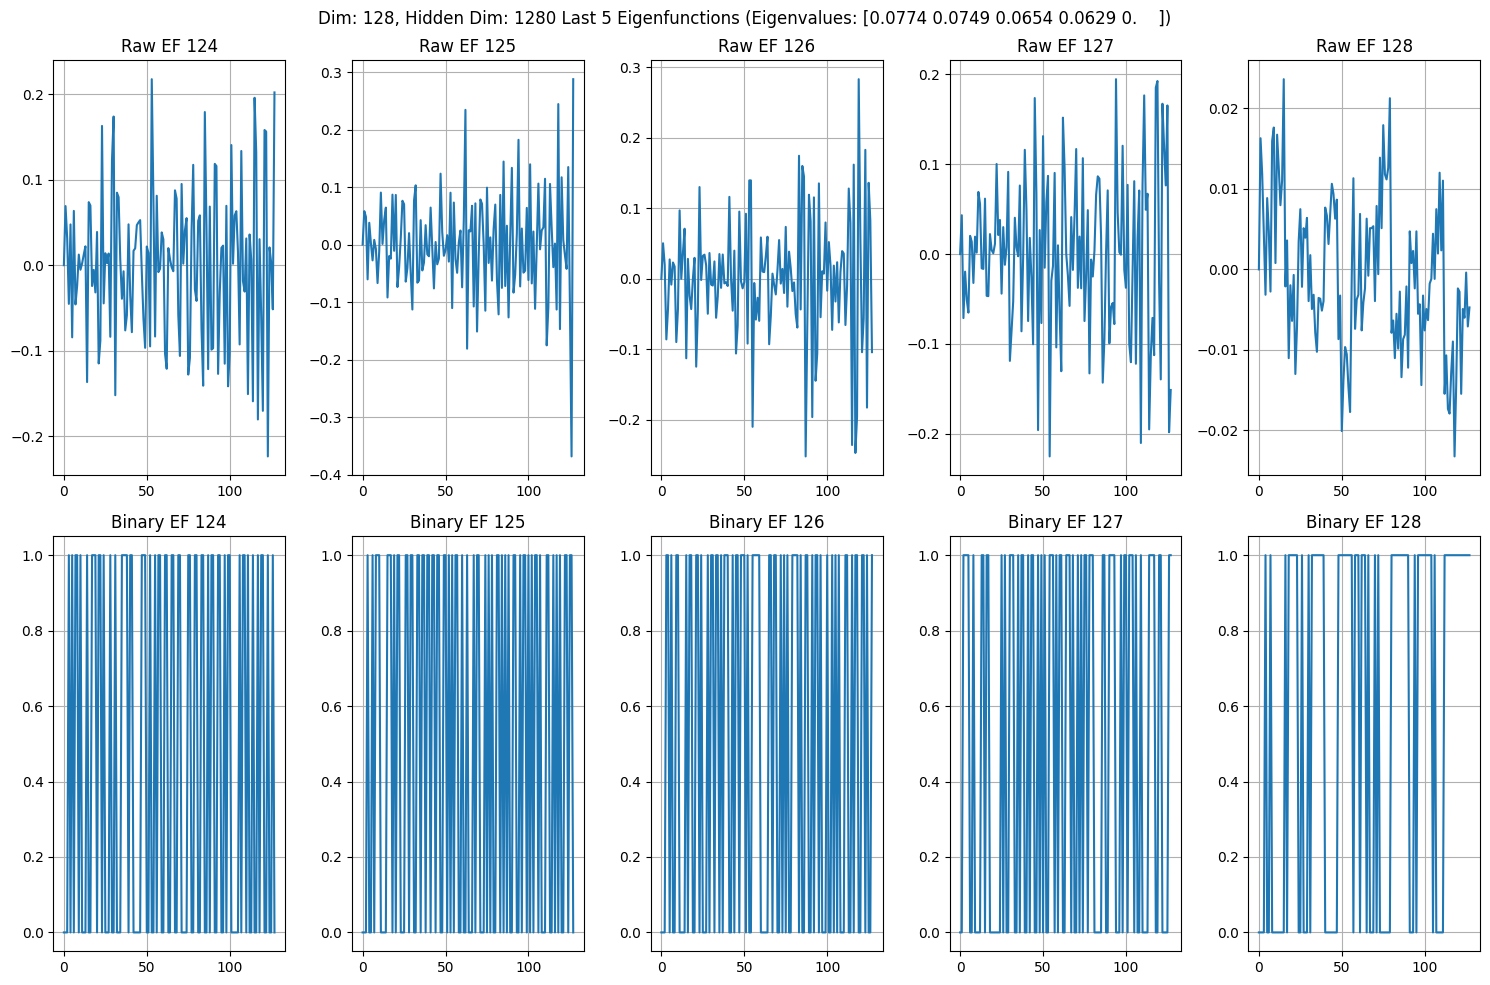

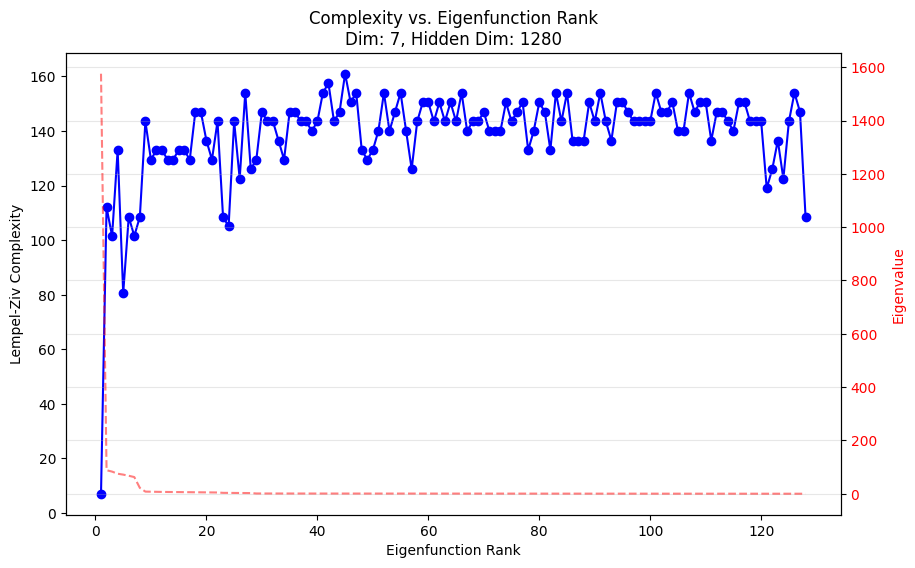

In [6]:
def plot_eigenfunction_examples(raw_eigenfunctions, binarized_eigenfunctions, eigenvalues, title_prefix=""):
    # Plot first 10 and last 10 eigenfunctions
    n_examples = 5
    
    # Create figure for first 10 eigenfunctions
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"{title_prefix} First {n_examples} Eigenfunctions (Eigenvalues: {eigenvalues[:n_examples].round(4)})")
    
    for i in range(n_examples):
        # Plot raw eigenfunction
        plt.subplot(2, n_examples, i + 1)
        plt.plot(raw_eigenfunctions[i])
        plt.title(f"Raw EF {i+1}")
        plt.grid(True)
        
        # Plot binarized eigenfunction
        plt.subplot(2, n_examples, i + 1 + n_examples)
        plt.plot(binarized_eigenfunctions[i])
        plt.title(f"Binary EF {i+1}")
        plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Create figure for last 10 eigenfunctions
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"{title_prefix} Last {n_examples} Eigenfunctions (Eigenvalues: {eigenvalues[-n_examples:].round(4)})")
    
    for i in range(-n_examples, 0):
        # Plot raw eigenfunction
        plt.subplot(2, n_examples, n_examples + i + 1)
        plt.plot(raw_eigenfunctions[i])
        plt.title(f"Raw EF {len(raw_eigenfunctions)+i+1}")
        plt.grid(True)
        
        # Plot binarized eigenfunction
        plt.subplot(2, n_examples, 2*n_examples + i + 1)
        plt.plot(binarized_eigenfunctions[i])
        plt.title(f"Binary EF {len(binarized_eigenfunctions)+i+1}")
        plt.grid(True)
    plt.tight_layout()
    plt.show()

def analyze_eigenfunctions(model, inputs, num_eigenfunctions=None):
    model.eval()
    
    with torch.no_grad():
        features = model.get_features(inputs)
        features = features.detach().numpy()
    
    # Transpose features to get correct dimensions for SVD
    features = features.T  # Now shape is (hidden_dim, num_samples)
    
    # Perform SVD
    U, s, Vt = svd(features, full_matrices=False)
    
    # Calculate eigenvalues
    eigenvalues = s ** 2
    
    if num_eigenfunctions is None:
        num_eigenfunctions = min(len(s), features.shape[0])
    
    raw_eigenfunctions = []
    binarized_eigenfunctions = []
    with torch.no_grad():
        readout_weights = model.fc2.weight.detach().numpy().flatten()
    
    for k in range(num_eigenfunctions):
        # Compute k-th eigenfunction: e_k(x) = u_k^T Φ(x) / s_k
        uk = U[:, k]
        eigenfunction_values = np.dot(features.T, uk) / s[k]
        raw_eigenfunctions.append(eigenfunction_values)
        
        # Apply readout map and binarize
        mapped_values = eigenfunction_values * readout_weights.sum()
        binarized_values = (mapped_values > 0).astype(int)
        binarized_eigenfunctions.append(binarized_values)
    
    # Plot eigenfunctions
    plot_eigenfunction_examples(raw_eigenfunctions, binarized_eigenfunctions, eigenvalues, 
                              title_prefix=f"Dim: {features.shape[1]}, Hidden Dim: {features.shape[0]}")
    
    # Calculate complexity for each eigenfunction
    complexities = np.array([K_lemp_ziv(ef) for ef in binarized_eigenfunctions])
    
    return eigenvalues[:num_eigenfunctions], binarized_eigenfunctions, complexities

def run_analysis(dim, hidden_dim, nl=2):
    # Generate data
    data = generate_data(dim)
    
    # Initialize model
    model = SimpleNN(input_dim=dim, hidden_dim=hidden_dim, nl=nl)
    
    # Run analysis
    eigenvalues, eigenfunctions, complexities = analyze_eigenfunctions(model, data)
    plot_complexity_vs_rank(complexities, eigenvalues, dim, hidden_dim)
    
    return eigenvalues, eigenfunctions, complexities

dim = 7
hidden_dim = 1280
eigenvalues, eigenfunctions, complexities = run_analysis(dim, hidden_dim)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
import itertools
import math


class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, nl=2):
        super(SimpleNN, self).__init__()
        self.nl = nl
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.relu = nn.ReLU()
        self.fcs = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim, bias=False) for _ in range(self.nl-1)])
        self.fc2 = nn.Linear(hidden_dim, 1, bias=False)
        
    def get_features(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        if self.nl > 1:
            for fc in self.fcs:
                x = fc(x)
                x = self.relu(x)
        return x
    
    def forward(self, x):
        features = self.get_features(x)
        output = self.fc2(features)
        return output

def generate_data(dim):
    inputs = [[0, 1] for _ in range(dim)]
    inputs = list(itertools.product(*inputs))
    return torch.Tensor(np.array(inputs))

def analyze_eigenfunctions(model, inputs, num_eigenfunctions=None):
    model.eval()
    
    with torch.no_grad():
        features = model.get_features(inputs)
        features = features.detach().numpy()
    
    # Transpose features to get correct dimensions for SVD
    features = features.T  # Now shape is (hidden_dim, num_samples)
    
    # Perform SVD
    U, s, Vt = svd(features, full_matrices=False)
    
    # Calculate eigenvalues
    eigenvalues = s ** 2
    
    if num_eigenfunctions is None:
        num_eigenfunctions = min(len(s), features.shape[0])
    
    eigenfunctions = []
    with torch.no_grad():
        readout_weights = model.fc2.weight.detach().numpy().flatten()
    print(readout_weights)
    for k in range(num_eigenfunctions):
        # Compute k-th eigenfunction: e_k(x) = u_k^T Φ(x) / s_k
        uk = U[:, k]
        eigenfunction_values = np.dot(features.T, uk) / s[k]
        print(eigenfunction_values.shape)
        # Apply readout map
        print(readout_weights.sum())
        mapped_values = eigenfunction_values * readout_weights.sum()
        print(readout_weights.sum().shape)
        # Binarize the output
        binarized_values = (mapped_values > 0).astype(int)
        eigenfunctions.append(binarized_values)
    
    # Calculate complexity for each eigenfunction
    complexities = np.array([K_lemp_ziv(ef) for ef in eigenfunctions])
    
    return eigenvalues[:num_eigenfunctions], eigenfunctions, complexities

def plot_complexity_vs_rank(complexities, eigenvalues, dim, hidden_dim, title="Complexity vs. Eigenfunction Rank"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(complexities) + 1), complexities,'o-', color='#6366F1', 
                    linewidth=1, markersize=2, label='Complexity')
    plt.xlabel('Eigenfunction Rank')
    plt.ylabel('Lempel-Ziv Complexity')
    
    ax2 = plt.twinx()
    ax2.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'r--', alpha=0.5, label='Eigenvalue')
    ax2.set_ylabel('Eigenvalue', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_xlim(0,2000)
    ax2.set_yscale('log')
    
    plt.title(f"{title}\nDim: {dim}, Hidden Dim: {hidden_dim}")
    plt.grid(True, alpha=0.3)
    plt.show()

def run_analysis(dim, hidden_dim, nl=2):
    # Generate data
    data = generate_data(dim)
    
    # Initialize model
    model = SimpleNN(input_dim=dim, hidden_dim=hidden_dim, nl=nl)
    
    # Run analysis
    eigenvalues, eigenfunctions, complexities = analyze_eigenfunctions(model, data)
    
    
    return eigenvalues, eigenfunctions, complexities


# Hyperparameters
dim = 7  # Input dimension
hidden_dim = 100  # Hidden layer dimension
nl = 4  # Number of layers

# Run analysis
eigenvalues, eigenfunctions, complexities = run_analysis(dim, hidden_dim, nl)

[[ 0.02884464 -0.06821557  0.0193841   0.0438819  -0.09902334 -0.01210183
   0.03180243 -0.05566401 -0.08213597  0.01059852 -0.03619316 -0.02114526
  -0.06548903 -0.03713211 -0.05188933  0.04951469 -0.01828405 -0.00018419
   0.05165821  0.06829573 -0.04407334 -0.02482846 -0.01768827 -0.07345972
  -0.08703064 -0.00273049 -0.0217738   0.01291375  0.05714717 -0.07751614
  -0.02784356  0.03786696  0.02537492  0.06067815  0.03781463  0.02857723
   0.04512279  0.06844604 -0.0210264  -0.09652259  0.04005902  0.01585981
  -0.07259443 -0.09622133 -0.02454027 -0.07287333 -0.00314049 -0.01794275
  -0.04886226 -0.08722606  0.08226681  0.09157222  0.01308868 -0.07910396
   0.04737044 -0.06828275 -0.08798476  0.07782775  0.00647427  0.00455164
  -0.03883065  0.04238762  0.06721427 -0.03875356 -0.08390354  0.09492283
   0.01133426 -0.03913437 -0.07341819  0.03733479  0.02265474  0.01954134
   0.017818    0.06985861  0.0983748   0.03522799  0.04190551 -0.00550131
   0.01381445  0.08549803  0.00960703 